In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import seaborn as sb
import scipy as sp
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["dir", "/b", "/a-d","input"], shell=True).decode("utf8"))

# Any results you write to the current directory are saved as output.
%matplotlib inline

BBTeamSeasonStats.csv
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
SampleSubmission.csv
Seasons.csv
Teams.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv



In [34]:
data_dir = 'input/'
df_seeds = pd.read_csv(data_dir + 'TourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')
df_BBSeason = pd.read_csv(data_dir + 'BBTeamSeasonStats.csv')

In [35]:
df_BBSeason.head()

Season  Team  WinLossPct  AvgPts  PtDiff  AvgRebounds  AvgAssists  \
0    2003  1291        0.41      63    -166           35          11   
1    2007  1144        0.41      76     -95           38          15   
2    2008  1208        0.50      67      29           39          11   
3    2013  1386        0.58      67     107           35          14   
4    2014  1450        0.30      61    -177           35          10   

   AvgTurnovers  AvgFouls  FGPct  FTPct  ThPct  AvgStealsPlusBlocks  \
0            15        21   0.39   0.70   0.32                   11   
1            17        19   0.44   0.72   0.33                   12   
2            14        18   0.43   0.67   0.33                   10   
3            11        13   0.44   0.70   0.34                   10   
4            11        18   0.40   0.66   0.33                    8   

   AvgPtsAgainst  OppFGPct  OppThPct  
0             69      0.45      0.40  
1             79      0.47      0.34  
2             66      0.43      0.31  
3             63      0.41      0.31  
4             67      0.46      0.37

In [36]:
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)

In [37]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [38]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [39]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [40]:
df_concat.head()

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff
0    1985   1116   1234         9          8          1
1    1985   1120   1345        11          6          5
2    1985   1207   1250         1         16        -15
3    1985   1229   1425         9          8          1
4    1985   1242   1325         3         14        -11

In [41]:
##Make a df to play with so I don't mess up df_concat
##We need to get other stats and differentials into this dataframe the same way as Seed_diff is there.
df_concat2 = df_concat

In [42]:
df_concat2.head()

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff
0    1985   1116   1234         9          8          1
1    1985   1120   1345        11          6          5
2    1985   1207   1250         1         16        -15
3    1985   1229   1425         9          8          1
4    1985   1242   1325         3         14        -11

In [43]:
df_BBSeason.head()

Season  Team  WinLossPct  AvgPts  PtDiff  AvgRebounds  AvgAssists  \
0    2003  1291        0.41      63    -166           35          11   
1    2007  1144        0.41      76     -95           38          15   
2    2008  1208        0.50      67      29           39          11   
3    2013  1386        0.58      67     107           35          14   
4    2014  1450        0.30      61    -177           35          10   

   AvgTurnovers  AvgFouls  FGPct  FTPct  ThPct  AvgStealsPlusBlocks  \
0            15        21   0.39   0.70   0.32                   11   
1            17        19   0.44   0.72   0.33                   12   
2            14        18   0.43   0.67   0.33                   10   
3            11        13   0.44   0.70   0.34                   10   
4            11        18   0.40   0.66   0.33                    8   

   AvgPtsAgainst  OppFGPct  OppThPct  
0             69      0.45      0.40  
1             79      0.47      0.34  
2             66      0.43      0.31  
3             63      0.41      0.31  
4             67      0.46      0.37

In [44]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [45]:
df_winseeds.head()

Season  Wteam  win_seed
0    1985   1207         1
1    1985   1210         2
2    1985   1228         3
3    1985   1260         4
4    1985   1374         5

In [46]:
df_WinStats = df_BBSeason.rename(columns={'Team':'Wteam'})

In [47]:
df_WinStats.head()

Season  Wteam  WinLossPct  AvgPts  PtDiff  AvgRebounds  AvgAssists  \
0    2003   1291        0.41      63    -166           35          11   
1    2007   1144        0.41      76     -95           38          15   
2    2008   1208        0.50      67      29           39          11   
3    2013   1386        0.58      67     107           35          14   
4    2014   1450        0.30      61    -177           35          10   

   AvgTurnovers  AvgFouls  FGPct  FTPct  ThPct  AvgStealsPlusBlocks  \
0            15        21   0.39   0.70   0.32                   11   
1            17        19   0.44   0.72   0.33                   12   
2            14        18   0.43   0.67   0.33                   10   
3            11        13   0.44   0.70   0.34                   10   
4            11        18   0.40   0.66   0.33                    8   

   AvgPtsAgainst  OppFGPct  OppThPct  
0             69      0.45      0.40  
1             79      0.47      0.34  
2             66      0.43      0.31  
3             63      0.41      0.31  
4             67      0.46      0.37

In [48]:
df_WinStats2 = pd.merge(left=df_winseeds, right=df_WinStats, on=['Season', 'Wteam'])

In [49]:
df_LossStats = df_BBSeason.rename(columns={'Team':'Lteam'})

In [50]:
df_LossStats2 = pd.merge(left=df_lossseeds, right=df_LossStats, on=['Season', 'Lteam'])

In [51]:
df_LossStats.head()

Season  Lteam  WinLossPct  AvgPts  PtDiff  AvgRebounds  AvgAssists  \
0    2003   1291        0.41      63    -166           35          11   
1    2007   1144        0.41      76     -95           38          15   
2    2008   1208        0.50      67      29           39          11   
3    2013   1386        0.58      67     107           35          14   
4    2014   1450        0.30      61    -177           35          10   

   AvgTurnovers  AvgFouls  FGPct  FTPct  ThPct  AvgStealsPlusBlocks  \
0            15        21   0.39   0.70   0.32                   11   
1            17        19   0.44   0.72   0.33                   12   
2            14        18   0.43   0.67   0.33                   10   
3            11        13   0.44   0.70   0.34                   10   
4            11        18   0.40   0.66   0.33                    8   

   AvgPtsAgainst  OppFGPct  OppThPct  
0             69      0.45      0.40  
1             79      0.47      0.34  
2             66      0.43      0.31  
3             63      0.41      0.31  
4             67      0.46      0.37

In [52]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])

In [53]:
# Use .add_prefix to add a prefix to each of the columns in your data frame
# Add W_ to each of the columns in the WinStats2 data frame
df_WinStatsPrefixed = df_WinStats2.add_prefix("W_")

# Add L_ to each of the columns in the LossStats2 data frame
df_LossStatsPrefixed = df_LossStats2.add_prefix("L_")

df_WinStatsPrefixed.head()

W_Season  W_Wteam  W_win_seed  W_WinLossPct  W_AvgPts  W_PtDiff  \
0      2003     1328           1          0.80        71       330   
1      2003     1448           2          0.83        78       313   
2      2003     1393           3          0.83        80       296   
3      2003     1257           4          0.80        81       401   
4      2003     1280           5          0.70        70       300   

   W_AvgRebounds  W_AvgAssists  W_AvgTurnovers  W_AvgFouls  W_FGPct  W_FTPct  \
0             37            14              11          18     0.45     0.71   
1             42            14              15          18     0.46     0.75   
2             41            14              13          16     0.47     0.69   
3             38            16              13          22     0.46     0.70   
4             37            14              15          15     0.47     0.68   

   W_ThPct  W_AvgStealsPlusBlocks  W_AvgPtsAgainst  W_OppFGPct  W_OppThPct  
0     0.39                     10               60        0.40        0.33  
1     0.34                     10               67        0.40        0.34  
2     0.33                     15               69        0.39        0.31  
3     0.36                     11               68        0.40        0.30  
4     0.34                     12               60        0.40        0.33

In [54]:
df_WinStatsPrefixed.head()

W_Season  W_Wteam  W_win_seed  W_WinLossPct  W_AvgPts  W_PtDiff  \
0      2003     1328           1          0.80        71       330   
1      2003     1448           2          0.83        78       313   
2      2003     1393           3          0.83        80       296   
3      2003     1257           4          0.80        81       401   
4      2003     1280           5          0.70        70       300   

   W_AvgRebounds  W_AvgAssists  W_AvgTurnovers  W_AvgFouls  W_FGPct  W_FTPct  \
0             37            14              11          18     0.45     0.71   
1             42            14              15          18     0.46     0.75   
2             41            14              13          16     0.47     0.69   
3             38            16              13          22     0.46     0.70   
4             37            14              15          15     0.47     0.68   

   W_ThPct  W_AvgStealsPlusBlocks  W_AvgPtsAgainst  W_OppFGPct  W_OppThPct  
0     0.39                     10               60        0.40        0.33  
1     0.34                     10               67        0.40        0.34  
2     0.33                     15               69        0.39        0.31  
3     0.36                     11               68        0.40        0.30  
4     0.34                     12               60        0.40        0.33

In [55]:
df_WinStatsPrefixed = df_WinStatsPrefixed.rename(columns={'W_Season':'Season', 'W_Wteam':'Wteam'})
df_LossStatsPrefixed = df_LossStatsPrefixed.rename(columns={'L_Season':'Season', 'L_Lteam':'Lteam'})

In [56]:
df_LossStatsPrefixed.head()

Season  Lteam  L_loss_seed  L_WinLossPct  L_AvgPts  L_PtDiff  \
0    2003   1328            1          0.80        71       330   
1    2003   1448            2          0.83        78       313   
2    2003   1393            3          0.83        80       296   
3    2003   1257            4          0.80        81       401   
4    2003   1280            5          0.70        70       300   

   L_AvgRebounds  L_AvgAssists  L_AvgTurnovers  L_AvgFouls  L_FGPct  L_FTPct  \
0             37            14              11          18     0.45     0.71   
1             42            14              15          18     0.46     0.75   
2             41            14              13          16     0.47     0.69   
3             38            16              13          22     0.46     0.70   
4             37            14              15          15     0.47     0.68   

   L_ThPct  L_AvgStealsPlusBlocks  L_AvgPtsAgainst  L_OppFGPct  L_OppThPct  
0     0.39                     10               60        0.40        0.33  
1     0.34                     10               67        0.40        0.34  
2     0.33                     15               69        0.39        0.31  
3     0.36                     11               68        0.40        0.30  
4     0.34                     12               60        0.40        0.33

In [57]:
df_concat2 = pd.merge(left=df_concat2, right=df_LossStatsPrefixed,  on=['Season', 'Lteam'])
df_concat3 = pd.merge(left=df_concat2, right=df_WinStatsPrefixed,  on=['Season', 'Wteam'])

In [58]:
##Use this dataframe to calculate stats for wins and losses in separate dataframes by just reversing the calculations.
##For example, for the winning team, calculate avg_point_diff as (W_AvgPts_x - L_AvgPts_x), 
##but in another dataframe for the losers calculate it as (L_AvgPts_x - W_AvgPts_x).
##Once all calculations are made in separate dataframes add the 'Result' column to each (like in this original notebook)
##and finally UNION all records.  This way, we have examples of both wins and losses with appropriate stats.
##Once this is all complete, drop all columns exept for Season, Wteam, LTeam, seed_diff, Result, and all calculated diffs.
##THAT should be our final data set.

df_concat3.head()

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  L_loss_seed  \
0    2003   1421   1411        16         16          0           16   
1    2003   1112   1436         1         16        -15           16   
2    2003   1112   1211         1          9         -8            9   
3    2003   1112   1323         1          5         -4            5   
4    2003   1113   1272        10          7          3            7   

   L_WinLossPct  L_AvgPts  L_PtDiff     ...      W_AvgAssists  W_AvgTurnovers  \
0          0.60        72        59     ...                13              16   
1          0.66        67       135     ...                17              14   
2          0.74        77       275     ...                17              14   
3          0.71        80       276     ...                17              14   
4          0.79        74       252     ...                15              14   

   W_AvgFouls  W_FGPct  W_FTPct  W_ThPct  W_AvgStealsPlusBlocks  \
0          19     0.43     0.76     0.36                     10   
1          17     0.46     0.70     0.35                     12   
2          17     0.46     0.70     0.35                     12   
3          17     0.46     0.70     0.35                     12   
4          19     0.48     0.67     0.32                      9   

   W_AvgPtsAgainst  W_OppFGPct  W_OppThPct  
0               78        0.46        0.37  
1               70        0.41        0.32  
2               70        0.41        0.32  
3               70        0.41        0.32  
4               69        0.45        0.34  

[5 rows x 36 columns]

In [59]:
# Winner Stats
# if you set a dataframe = to another dataframe it will modify the the original data frame.  
# Use copy to preserve and not accidentally do bad things and upset yourself later
df_WinnerStats = df_concat3.copy(deep=True)

# Calculate Differentials
df_WinnerStats['diff_WinLossPct'] = df_WinnerStats.W_WinLossPct - df_WinnerStats.L_WinLossPct
df_WinnerStats['diff_AvgPts'] = df_WinnerStats.W_AvgPts - df_WinnerStats.L_AvgPts
df_WinnerStats['diff_PtDiff'] = df_WinnerStats.W_PtDiff - df_WinnerStats.L_PtDiff
df_WinnerStats['diff_AvgRebounds'] = df_WinnerStats.W_AvgRebounds - df_WinnerStats.L_AvgRebounds
df_WinnerStats['diff_AvgAssists'] = df_WinnerStats.W_AvgAssists - df_WinnerStats.L_AvgAssists
df_WinnerStats['diff_AvgTurnovers'] = df_WinnerStats.W_AvgTurnovers - df_WinnerStats.L_AvgTurnovers
df_WinnerStats['diff_AvgFouls'] = df_WinnerStats.W_AvgFouls - df_WinnerStats.L_AvgFouls
df_WinnerStats['diff_FGPct'] = df_WinnerStats.W_FGPct - df_WinnerStats.L_FGPct
df_WinnerStats['diff_FTPct'] = df_WinnerStats.W_FTPct - df_WinnerStats.L_FTPct
df_WinnerStats['diff_ThPct'] = df_WinnerStats.W_ThPct - df_WinnerStats.L_ThPct
df_WinnerStats['diff_AvgStealsPlusBlocks'] = df_WinnerStats.W_AvgStealsPlusBlocks - df_WinnerStats.L_AvgStealsPlusBlocks
df_WinnerStats['diff_AvgPtsAgainst'] = df_WinnerStats.W_AvgPtsAgainst - df_WinnerStats.L_AvgPtsAgainst
df_WinnerStats['diff_OppFGPct'] = df_WinnerStats.W_OppFGPct - df_WinnerStats.L_OppFGPct
df_WinnerStats['diff_OppThPct'] = df_WinnerStats.W_OppThPct - df_WinnerStats.L_OppThPct
df_WinnerStats['Result'] = 1




In [60]:
df_WinnerStats

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  L_loss_seed  \
0      2003   1421   1411        16         16          0           16   
1      2003   1112   1436         1         16        -15           16   
2      2003   1112   1211         1          9         -8            9   
3      2003   1112   1323         1          5         -4            5   
4      2003   1113   1272        10          7          3            7   
5      2003   1141   1166        11          6          5            6   
6      2003   1143   1301         8          9         -1            9   
7      2003   1163   1140         5         12         -7           12   
8      2003   1163   1390         5          4          1            4   
9      2003   1181   1161         3         14        -11           14   
10     2003   1181   1141         3         11         -8           11   
11     2003   1211   1153         9          8          1            8   
12     2003   1228   1443         4         13         -9           13   
13     2003   1242   1429         2         15        -13           15   
14     2003   1242   1113         2         10         -8           10   
15     2003   1242   1181         2          3         -1            3   
16     2003   1242   1112         2          1          1            1   
17     2003   1242   1266         2          3         -1            3   
18     2003   1266   1221         3         14        -11           14   
19     2003   1266   1281         3          6         -3            6   
20     2003   1266   1338         3          2          1            2   
21     2003   1266   1246         3          1          2            1   
22     2003   1281   1356         6         11         -5           11   
23     2003   1323   1454         5         12         -7           12   
24     2003   1323   1228         5          4          1            4   
25     2003   1328   1354         1         16        -15           16   
26     2003   1328   1143         1          8         -7            8   
27     2003   1328   1139         1         12        -11           12   
28     2003   1390   1360         4         13         -9           13   
29     2003   1409   1173        13          4          9            4   
..      ...    ...    ...       ...        ...        ...          ...   
884    2016   1292   1277        15          2         13            2   
885    2016   1320   1400        11          6          5            6   
886    2016   1323   1276         6         11         -5           11   
887    2016   1323   1372         6         14         -8           14   
888    2016   1323   1458         6          7         -1            7   
889    2016   1328   1167         2         15        -13           15   
890    2016   1328   1433         2         10         -8           10   
891    2016   1328   1401         2          3         -1            3   
892    2016   1328   1332         2          1          1            1   
893    2016   1332   1221         1         16        -15           16   
894    2016   1332   1386         1          8         -7            8   
895    2016   1332   1181         1          4         -3            4   
896    2016   1372   1452        14          3         11            3   
897    2016   1386   1153         8          9         -1            9   
898    2016   1393   1173        10          7          3            7   
899    2016   1393   1292        10         15         -5           15   
900    2016   1393   1211        10         11         -1           11   
901    2016   1393   1438        10          1          9            1   
902    2016   1401   1453         3         14        -11           14   
903    2016   1401   1320         3         11         -8           11   
904    2016   1433   1333        10          7          3            7   
905    2016   1437   1421         2         15        -13           15   
906    20

In [61]:
df_WinnerStats.columns

Index(['Season', 'Wteam', 'Lteam', 'win_seed', 'loss_seed', 'seed_diff',
       'L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct', 'diff_WinLossPct',
       'diff_AvgPts', 'diff_PtDiff', 'diff_AvgRebounds', 'diff_AvgAssists',
       'diff_AvgTurnovers', 'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct',
       'diff_ThPct', 'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst',
       'diff_OppFGPct', 'diff_OppThPct', 'Result'],
      dtype='object')

In [62]:
# Loser Stats
df_LoserStats = df_concat3.copy(deep=True)

# Calculate Differentials
df_LoserStats['diff_WinLossPct'] = df_WinnerStats.L_WinLossPct - df_WinnerStats.W_WinLossPct
df_LoserStats['diff_AvgPts'] = df_WinnerStats.L_AvgPts - df_WinnerStats.W_AvgPts
df_LoserStats['diff_PtDiff'] = df_WinnerStats.L_PtDiff - df_WinnerStats.W_PtDiff
df_LoserStats['diff_AvgRebounds'] = df_WinnerStats.L_AvgRebounds - df_WinnerStats.W_AvgRebounds
df_LoserStats['diff_AvgAssists'] = df_WinnerStats.L_AvgAssists - df_WinnerStats.W_AvgAssists
df_LoserStats['diff_AvgTurnovers'] = df_WinnerStats.L_AvgTurnovers - df_WinnerStats.W_AvgTurnovers
df_LoserStats['diff_AvgFouls'] = df_WinnerStats.L_AvgFouls - df_WinnerStats.W_AvgFouls
df_LoserStats['diff_FGPct'] = df_WinnerStats.L_FGPct - df_WinnerStats.W_FGPct
df_LoserStats['diff_FTPct'] = df_WinnerStats.L_FTPct - df_WinnerStats.W_FTPct
df_LoserStats['diff_ThPct'] = df_WinnerStats.L_ThPct - df_WinnerStats.W_ThPct
df_LoserStats['diff_AvgStealsPlusBlocks'] = df_WinnerStats.L_AvgStealsPlusBlocks - df_WinnerStats.W_AvgStealsPlusBlocks
df_LoserStats['diff_AvgPtsAgainst'] = df_WinnerStats.L_AvgPtsAgainst - df_WinnerStats.W_AvgPtsAgainst
df_LoserStats['diff_OppFGPct'] = df_WinnerStats.L_OppFGPct - df_WinnerStats.W_OppFGPct
df_LoserStats['diff_OppThPct'] = df_WinnerStats.L_OppThPct - df_WinnerStats.W_OppThPct
df_LoserStats['Result'] = 0

In [63]:
df_LoserStats

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  L_loss_seed  \
0      2003   1421   1411        16         16          0           16   
1      2003   1112   1436         1         16        -15           16   
2      2003   1112   1211         1          9         -8            9   
3      2003   1112   1323         1          5         -4            5   
4      2003   1113   1272        10          7          3            7   
5      2003   1141   1166        11          6          5            6   
6      2003   1143   1301         8          9         -1            9   
7      2003   1163   1140         5         12         -7           12   
8      2003   1163   1390         5          4          1            4   
9      2003   1181   1161         3         14        -11           14   
10     2003   1181   1141         3         11         -8           11   
11     2003   1211   1153         9          8          1            8   
12     2003   1228   1443         4         13         -9           13   
13     2003   1242   1429         2         15        -13           15   
14     2003   1242   1113         2         10         -8           10   
15     2003   1242   1181         2          3         -1            3   
16     2003   1242   1112         2          1          1            1   
17     2003   1242   1266         2          3         -1            3   
18     2003   1266   1221         3         14        -11           14   
19     2003   1266   1281         3          6         -3            6   
20     2003   1266   1338         3          2          1            2   
21     2003   1266   1246         3          1          2            1   
22     2003   1281   1356         6         11         -5           11   
23     2003   1323   1454         5         12         -7           12   
24     2003   1323   1228         5          4          1            4   
25     2003   1328   1354         1         16        -15           16   
26     2003   1328   1143         1          8         -7            8   
27     2003   1328   1139         1         12        -11           12   
28     2003   1390   1360         4         13         -9           13   
29     2003   1409   1173        13          4          9            4   
..      ...    ...    ...       ...        ...        ...          ...   
884    2016   1292   1277        15          2         13            2   
885    2016   1320   1400        11          6          5            6   
886    2016   1323   1276         6         11         -5           11   
887    2016   1323   1372         6         14         -8           14   
888    2016   1323   1458         6          7         -1            7   
889    2016   1328   1167         2         15        -13           15   
890    2016   1328   1433         2         10         -8           10   
891    2016   1328   1401         2          3         -1            3   
892    2016   1328   1332         2          1          1            1   
893    2016   1332   1221         1         16        -15           16   
894    2016   1332   1386         1          8         -7            8   
895    2016   1332   1181         1          4         -3            4   
896    2016   1372   1452        14          3         11            3   
897    2016   1386   1153         8          9         -1            9   
898    2016   1393   1173        10          7          3            7   
899    2016   1393   1292        10         15         -5           15   
900    2016   1393   1211        10         11         -1           11   
901    2016   1393   1438        10          1          9            1   
902    2016   1401   1453         3         14        -11           14   
903    2016   1401   1320         3         11         -8           11   
904    2016   1433   1333        10          7          3            7   
905    2016   1437   1421         2         15        -13           15   
906    20

In [64]:
df_LoserStats.columns

Index(['Season', 'Wteam', 'Lteam', 'win_seed', 'loss_seed', 'seed_diff',
       'L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct', 'diff_WinLossPct',
       'diff_AvgPts', 'diff_PtDiff', 'diff_AvgRebounds', 'diff_AvgAssists',
       'diff_AvgTurnovers', 'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct',
       'diff_ThPct', 'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst',
       'diff_OppFGPct', 'diff_OppThPct', 'Result'],
      dtype='object')

In [65]:
df_WinnerStats

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  L_loss_seed  \
0      2003   1421   1411        16         16          0           16   
1      2003   1112   1436         1         16        -15           16   
2      2003   1112   1211         1          9         -8            9   
3      2003   1112   1323         1          5         -4            5   
4      2003   1113   1272        10          7          3            7   
5      2003   1141   1166        11          6          5            6   
6      2003   1143   1301         8          9         -1            9   
7      2003   1163   1140         5         12         -7           12   
8      2003   1163   1390         5          4          1            4   
9      2003   1181   1161         3         14        -11           14   
10     2003   1181   1141         3         11         -8           11   
11     2003   1211   1153         9          8          1            8   
12     2003   1228   1443         4         13         -9           13   
13     2003   1242   1429         2         15        -13           15   
14     2003   1242   1113         2         10         -8           10   
15     2003   1242   1181         2          3         -1            3   
16     2003   1242   1112         2          1          1            1   
17     2003   1242   1266         2          3         -1            3   
18     2003   1266   1221         3         14        -11           14   
19     2003   1266   1281         3          6         -3            6   
20     2003   1266   1338         3          2          1            2   
21     2003   1266   1246         3          1          2            1   
22     2003   1281   1356         6         11         -5           11   
23     2003   1323   1454         5         12         -7           12   
24     2003   1323   1228         5          4          1            4   
25     2003   1328   1354         1         16        -15           16   
26     2003   1328   1143         1          8         -7            8   
27     2003   1328   1139         1         12        -11           12   
28     2003   1390   1360         4         13         -9           13   
29     2003   1409   1173        13          4          9            4   
..      ...    ...    ...       ...        ...        ...          ...   
884    2016   1292   1277        15          2         13            2   
885    2016   1320   1400        11          6          5            6   
886    2016   1323   1276         6         11         -5           11   
887    2016   1323   1372         6         14         -8           14   
888    2016   1323   1458         6          7         -1            7   
889    2016   1328   1167         2         15        -13           15   
890    2016   1328   1433         2         10         -8           10   
891    2016   1328   1401         2          3         -1            3   
892    2016   1328   1332         2          1          1            1   
893    2016   1332   1221         1         16        -15           16   
894    2016   1332   1386         1          8         -7            8   
895    2016   1332   1181         1          4         -3            4   
896    2016   1372   1452        14          3         11            3   
897    2016   1386   1153         8          9         -1            9   
898    2016   1393   1173        10          7          3            7   
899    2016   1393   1292        10         15         -5           15   
900    2016   1393   1211        10         11         -1           11   
901    2016   1393   1438        10          1          9            1   
902    2016   1401   1453         3         14        -11           14   
903    2016   1401   1320         3         11         -8           11   
904    2016   1433   1333        10          7          3            7   
905    2016   1437   1421         2         15        -13           15   
906    20

In [66]:
df_LoserStats

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  L_loss_seed  \
0      2003   1421   1411        16         16          0           16   
1      2003   1112   1436         1         16        -15           16   
2      2003   1112   1211         1          9         -8            9   
3      2003   1112   1323         1          5         -4            5   
4      2003   1113   1272        10          7          3            7   
5      2003   1141   1166        11          6          5            6   
6      2003   1143   1301         8          9         -1            9   
7      2003   1163   1140         5         12         -7           12   
8      2003   1163   1390         5          4          1            4   
9      2003   1181   1161         3         14        -11           14   
10     2003   1181   1141         3         11         -8           11   
11     2003   1211   1153         9          8          1            8   
12     2003   1228   1443         4         13         -9           13   
13     2003   1242   1429         2         15        -13           15   
14     2003   1242   1113         2         10         -8           10   
15     2003   1242   1181         2          3         -1            3   
16     2003   1242   1112         2          1          1            1   
17     2003   1242   1266         2          3         -1            3   
18     2003   1266   1221         3         14        -11           14   
19     2003   1266   1281         3          6         -3            6   
20     2003   1266   1338         3          2          1            2   
21     2003   1266   1246         3          1          2            1   
22     2003   1281   1356         6         11         -5           11   
23     2003   1323   1454         5         12         -7           12   
24     2003   1323   1228         5          4          1            4   
25     2003   1328   1354         1         16        -15           16   
26     2003   1328   1143         1          8         -7            8   
27     2003   1328   1139         1         12        -11           12   
28     2003   1390   1360         4         13         -9           13   
29     2003   1409   1173        13          4          9            4   
..      ...    ...    ...       ...        ...        ...          ...   
884    2016   1292   1277        15          2         13            2   
885    2016   1320   1400        11          6          5            6   
886    2016   1323   1276         6         11         -5           11   
887    2016   1323   1372         6         14         -8           14   
888    2016   1323   1458         6          7         -1            7   
889    2016   1328   1167         2         15        -13           15   
890    2016   1328   1433         2         10         -8           10   
891    2016   1328   1401         2          3         -1            3   
892    2016   1328   1332         2          1          1            1   
893    2016   1332   1221         1         16        -15           16   
894    2016   1332   1386         1          8         -7            8   
895    2016   1332   1181         1          4         -3            4   
896    2016   1372   1452        14          3         11            3   
897    2016   1386   1153         8          9         -1            9   
898    2016   1393   1173        10          7          3            7   
899    2016   1393   1292        10         15         -5           15   
900    2016   1393   1211        10         11         -1           11   
901    2016   1393   1438        10          1          9            1   
902    2016   1401   1453         3         14        -11           14   
903    2016   1401   1320         3         11         -8           11   
904    2016   1433   1333        10          7          3            7   
905    2016   1437   1421         2         15        -13           15   
906    20

In [67]:
df_LoserStats

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  L_loss_seed  \
0      2003   1421   1411        16         16          0           16   
1      2003   1112   1436         1         16        -15           16   
2      2003   1112   1211         1          9         -8            9   
3      2003   1112   1323         1          5         -4            5   
4      2003   1113   1272        10          7          3            7   
5      2003   1141   1166        11          6          5            6   
6      2003   1143   1301         8          9         -1            9   
7      2003   1163   1140         5         12         -7           12   
8      2003   1163   1390         5          4          1            4   
9      2003   1181   1161         3         14        -11           14   
10     2003   1181   1141         3         11         -8           11   
11     2003   1211   1153         9          8          1            8   
12     2003   1228   1443         4         13         -9           13   
13     2003   1242   1429         2         15        -13           15   
14     2003   1242   1113         2         10         -8           10   
15     2003   1242   1181         2          3         -1            3   
16     2003   1242   1112         2          1          1            1   
17     2003   1242   1266         2          3         -1            3   
18     2003   1266   1221         3         14        -11           14   
19     2003   1266   1281         3          6         -3            6   
20     2003   1266   1338         3          2          1            2   
21     2003   1266   1246         3          1          2            1   
22     2003   1281   1356         6         11         -5           11   
23     2003   1323   1454         5         12         -7           12   
24     2003   1323   1228         5          4          1            4   
25     2003   1328   1354         1         16        -15           16   
26     2003   1328   1143         1          8         -7            8   
27     2003   1328   1139         1         12        -11           12   
28     2003   1390   1360         4         13         -9           13   
29     2003   1409   1173        13          4          9            4   
..      ...    ...    ...       ...        ...        ...          ...   
884    2016   1292   1277        15          2         13            2   
885    2016   1320   1400        11          6          5            6   
886    2016   1323   1276         6         11         -5           11   
887    2016   1323   1372         6         14         -8           14   
888    2016   1323   1458         6          7         -1            7   
889    2016   1328   1167         2         15        -13           15   
890    2016   1328   1433         2         10         -8           10   
891    2016   1328   1401         2          3         -1            3   
892    2016   1328   1332         2          1          1            1   
893    2016   1332   1221         1         16        -15           16   
894    2016   1332   1386         1          8         -7            8   
895    2016   1332   1181         1          4         -3            4   
896    2016   1372   1452        14          3         11            3   
897    2016   1386   1153         8          9         -1            9   
898    2016   1393   1173        10          7          3            7   
899    2016   1393   1292        10         15         -5           15   
900    2016   1393   1211        10         11         -1           11   
901    2016   1393   1438        10          1          9            1   
902    2016   1401   1453         3         14        -11           14   
903    2016   1401   1320         3         11         -8           11   
904    2016   1433   1333        10          7          3            7   
905    2016   1437   1421         2         15        -13           15   
906    20

In [68]:
concats = [df_WinnerStats, df_LoserStats]
df_Concats = df_WinnerStats.append(df_LoserStats)
df_Concats

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  L_loss_seed  \
0      2003   1421   1411        16         16          0           16   
1      2003   1112   1436         1         16        -15           16   
2      2003   1112   1211         1          9         -8            9   
3      2003   1112   1323         1          5         -4            5   
4      2003   1113   1272        10          7          3            7   
5      2003   1141   1166        11          6          5            6   
6      2003   1143   1301         8          9         -1            9   
7      2003   1163   1140         5         12         -7           12   
8      2003   1163   1390         5          4          1            4   
9      2003   1181   1161         3         14        -11           14   
10     2003   1181   1141         3         11         -8           11   
11     2003   1211   1153         9          8          1            8   
12     2003   1228   1443         4         13         -9           13   
13     2003   1242   1429         2         15        -13           15   
14     2003   1242   1113         2         10         -8           10   
15     2003   1242   1181         2          3         -1            3   
16     2003   1242   1112         2          1          1            1   
17     2003   1242   1266         2          3         -1            3   
18     2003   1266   1221         3         14        -11           14   
19     2003   1266   1281         3          6         -3            6   
20     2003   1266   1338         3          2          1            2   
21     2003   1266   1246         3          1          2            1   
22     2003   1281   1356         6         11         -5           11   
23     2003   1323   1454         5         12         -7           12   
24     2003   1323   1228         5          4          1            4   
25     2003   1328   1354         1         16        -15           16   
26     2003   1328   1143         1          8         -7            8   
27     2003   1328   1139         1         12        -11           12   
28     2003   1390   1360         4         13         -9           13   
29     2003   1409   1173        13          4          9            4   
..      ...    ...    ...       ...        ...        ...          ...   
884    2016   1292   1277        15          2         13            2   
885    2016   1320   1400        11          6          5            6   
886    2016   1323   1276         6         11         -5           11   
887    2016   1323   1372         6         14         -8           14   
888    2016   1323   1458         6          7         -1            7   
889    2016   1328   1167         2         15        -13           15   
890    2016   1328   1433         2         10         -8           10   
891    2016   1328   1401         2          3         -1            3   
892    2016   1328   1332         2          1          1            1   
893    2016   1332   1221         1         16        -15           16   
894    2016   1332   1386         1          8         -7            8   
895    2016   1332   1181         1          4         -3            4   
896    2016   1372   1452        14          3         11            3   
897    2016   1386   1153         8          9         -1            9   
898    2016   1393   1173        10          7          3            7   
899    2016   1393   1292        10         15         -5           15   
900    2016   1393   1211        10         11         -1           11   
901    2016   1393   1438        10          1          9            1   
902    2016   1401   1453         3         14        -11           14   
903    2016   1401   1320         3         11         -8           11   
904    2016   1433   1333        10          7          3            7   
905    2016   1437   1421         2         15        -13           15   
906    20

In [69]:
df_Concats.columns

Index(['Season', 'Wteam', 'Lteam', 'win_seed', 'loss_seed', 'seed_diff',
       'L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct', 'diff_WinLossPct',
       'diff_AvgPts', 'diff_PtDiff', 'diff_AvgRebounds', 'diff_AvgAssists',
       'diff_AvgTurnovers', 'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct',
       'diff_ThPct', 'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst',
       'diff_OppFGPct', 'diff_OppThPct', 'Result'],
      dtype='object')

In [70]:
df_Concats.drop(labels=['L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct'],inplace=True, axis=1)



In [71]:
df_Concats

Season  Wteam  Lteam  win_seed  loss_seed  seed_diff  diff_WinLossPct  \
0      2003   1421   1411        16         16          0            -0.15   
1      2003   1112   1436         1         16        -15             0.23   
2      2003   1112   1211         1          9         -8             0.15   
3      2003   1112   1323         1          5         -4             0.18   
4      2003   1113   1272        10          7          3            -0.17   
5      2003   1141   1166        11          6          5            -0.09   
6      2003   1143   1301         8          9         -1             0.12   
7      2003   1163   1140         5         12         -7            -0.04   
8      2003   1163   1390         5          4          1            -0.04   
9      2003   1181   1161         3         14        -11             0.23   
10     2003   1181   1141         3         11         -8             0.01   
11     2003   1211   1153         9          8          1             0.13   
12     2003   1228   1443         4         13         -9             0.06   
13     2003   1242   1429         2         15        -13             0.04   
14     2003   1242   1113         2         10         -8             0.15   
15     2003   1242   1181         2          3         -1            -0.03   
16     2003   1242   1112         2          1          1            -0.12   
17     2003   1242   1266         2          3         -1            -0.05   
18     2003   1266   1221         3         14        -11            -0.04   
19     2003   1266   1281         3          6         -3             0.14   
20     2003   1266   1338         3          2          1            -0.05   
21     2003   1266   1246         3          1          2            -0.09   
22     2003   1281   1356         6         11         -5            -0.12   
23     2003   1323   1454         5         12         -7            -0.06   
24     2003   1323   1228         5          4          1            -0.09   
25     2003   1328   1354         1         16        -15             0.13   
26     2003   1328   1143         1          8         -7             0.08   
27     2003   1328   1139         1         12        -11            -0.03   
28     2003   1390   1360         4         13         -9             0.13   
29     2003   1409   1173        13          4          9            -0.12   
..      ...    ...    ...       ...        ...        ...              ...   
884    2016   1292   1277        15          2         13             0.14   
885    2016   1320   1400        11          6          5            -0.01   
886    2016   1323   1276         6         11         -5            -0.02   
887    2016   1323   1372         6         14         -8             0.16   
888    2016   1323   1458         6          7         -1            -0.03   
889    2016   1328   1167         2         15        -13            -0.06   
890    2016   1328   1433         2         10         -8            -0.07   
891    2016   1328   1401         2          3         -1            -0.02   
892    2016   1328   1332         2          1          1             0.04   
893    2016   1332   1221         1         16        -15            -0.40   
894    2016   1332   1386         1          8         -7            -0.03   
895    2016   1332   1181         1          4         -3            -0.12   
896    2016   1372   1452        14          3         11            -0.06   
897    2016   1386   1153         8          9         -1            -0.10   
898    2016   1393   1173        10          7          3             0.19   
899    2016   1393   1292        10         15         -5             0.12   
900    2016   1393   1211        10         11         -1             0.19   
901    2016   1393   1438        10          1          9             0.20   
902    2016   1401   1453         3         14        -11            -0.12   
903    2016   1401   1320  

In [72]:
df_Concats.describe()

Season        Wteam        Lteam     win_seed    loss_seed  \
count  1828.000000  1828.000000  1828.000000  1828.000000  1828.000000   
mean   2009.578775  1294.508753  1294.598468     5.112691     8.805252   
std       4.037974   102.358912   106.976007     3.982913     4.630086   
min    2003.000000  1104.000000  1102.000000     1.000000     1.000000   
25%    2006.000000  1211.000000  1208.000000     2.000000     5.000000   
50%    2010.000000  1277.000000  1295.000000     4.000000     9.000000   
75%    2013.000000  1393.000000  1393.000000     8.000000    13.000000   
max    2016.000000  1463.000000  1463.000000    16.000000    16.000000   

         seed_diff  diff_WinLossPct  diff_AvgPts  diff_PtDiff  \
count  1828.000000     1.828000e+03   1828.00000  1828.000000   
mean     -3.692560     2.556914e-17      0.00000     0.000000   
std       6.507678     1.421625e-01      7.25054   205.540046   
min     -15.000000    -6.300000e-01    -23.00000  -740.000000   
25%      -8.000000    -9.000000e-02     -5.00000  -127.000000   
50%      -3.500000     0.000000e+00      0.00000     0.000000   
75%       1.000000     9.000000e-02      5.00000   127.000000   
max      13.000000     6.300000e-01     23.00000   740.000000   

       diff_AvgRebounds     ...       diff_AvgTurnovers  diff_AvgFouls  \
count        1828.00000     ...             1828.000000    1828.000000   
mean            0.00000     ...                0.000000       0.000000   
std             3.73375     ...                2.147541       2.565187   
min           -18.00000     ...               -8.000000      -7.000000   
25%            -2.00000     ...               -1.000000      -2.000000   
50%             0.00000     ...                0.000000       0.000000   
75%             2.00000     ...                1.000000       2.000000   
max            18.00000     ...                8.000000       7.000000   

         diff_FGPct    diff_FTPct    diff_ThPct  diff_AvgStealsPlusBlocks  \
count  1.828000e+03  1.828000e+03  1.828000e+03               1828.000000   
mean   6.194899e-18 -1.396889e-18 -1.852396e-18                  0.000000   
std    3.211399e-02  5.158463e-02  3.787312e-02                  2.981975   
min   -1.100000e-01 -1.700000e-01 -1.400000e-01                 -9.000000   
25%   -2.000000e-02 -4.000000e-02 -2.000000e-02                 -2.000000   
50%    0.000000e+00  0.000000e+00  0.000000e+00                  0.000000   
75%    2.000000e-02  4.000000e-02  2.000000e-02                  2.000000   
max    1.100000e-01  1.700000e-01  1.400000e-01                  9.000000   

       diff_AvgPtsAgainst  diff_OppFGPct  diff_OppThPct       Result  
count         1828.000000   1.828000e+03   1.828000e+03  1828.000000  
mean             0.000000   2.125701e-19   1.245053e-18     0.500000  
std              6.378501   3.126594e-02   3.153438e-02     0.500137  
min            -25.000000  -1.200000e-01  -1.000000e-01     0.000000  
25%             -4.000000  -2.000000e-02  -2.000000e-02     0.000000  
50%              0.000000   0.000000e+00   0.000000e+00     0.500000  
75%              4.000000   2.000000e-02   2.000000e-02     1.000000  
max             25.000000   1.200000e-01   1.000000e-01     1.000000  

[8 rows x 21 columns]

In [73]:
df_Concats['Result'].sum()

914

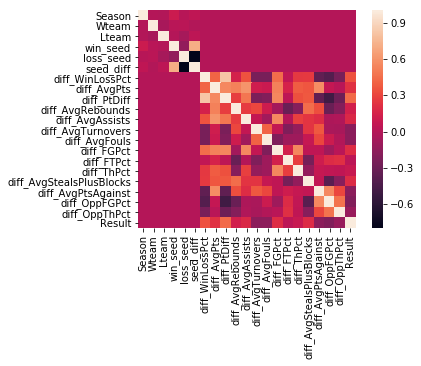

In [75]:
sb.heatmap(df_Concats.corr(),annot=False, square=True)